In [870]:
import json
import os

import numpy as np
import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec


In [871]:
plt.rcParams['text.usetex'] = True
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300

plt.rcParams['savefig.format'] = 'pdf'


sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")


In [872]:
only_val_plot = True
save_figures = True
# save_figures = False

# data_arch = 'CIFAR'
data_arch = 'MNIST'


attack_trained = 'FGSM-RS'
attack_trained_tex = 'FGSM-RS'
_folder_path = f'../validation_results/{data_arch}/FGSM-RS'



# attack_trained = 'PGD5-0.4'
# # attack_trained_tex = 'PGD$^{5}_{0.012}$'
# attack_trained_tex = 'PGD$^{5}_{0.12}$'
# _folder_path = f'../validation_results/{data_arch}/PGD5-0.4'



# attack_trained = 'CW20-0.1'
# attack_trained_tex = 'CW$^{20}_{0.1}$'
# _folder_path = f'../validation_results/{data_arch}/CW20-0.1'



# Reading txt files in folder_path, loading as JSON:



_folder_contents = os.listdir(_folder_path)
_validation_result_files = []
validation_result_json = {}


for _file in _folder_contents:
    if _file.endswith(".txt") and "timing" not in _file:
        _validation_result_files.append(_file)
        # reading the data from the file
        with open(_folder_path + "/" + _file) as f:
            _data = json.load(f)
            validation_result_json[_file] = _data

with open('./attack_id_to_texnames.txt') as _file:
    name_transform_dict = json.load(_file)


In [873]:
# Create dict of attack_id -> eps list:

attack_eps_dict = {}
first_val_result = validation_result_json[list(validation_result_json.keys())[0]]

for attack_id in first_val_result.keys():

    if "FGSM" in attack_id and "L2" in attack_id:
        attack_eps_dict[attack_id] = list(first_val_result[attack_id].keys())
    elif "FGSM" in attack_id:
        attack_eps_dict[attack_id] = list(first_val_result[attack_id].keys())
    elif "PGD" in attack_id:
        attack_eps_dict[attack_id] = list(first_val_result[attack_id].keys())
    elif "CW" in attack_id:
        attack_eps_dict[attack_id] = list(first_val_result[attack_id].keys())


In [874]:

def getDataFrameForMetric(metric_id:str = "Top_1_Accuracy"):

    data_list = []
#  Dict is JSON formatted as [model_id][attack_id][eps_value][metric]
    for model_id, model_data in validation_result_json.items():
        model_name_for_row = model_id[:-7]

        # Determine model specific params        
        if "base_model" in model_id:
            model_run = 0
            model_name_for_row = 'base_model'
        else:
            model_run = 0 if "_v0" in model_id else 1 if "_v1" in model_id else 2 if "_v2" in model_id else -1


        #  Loop over attacks used for this model
        for attack_id, attack_data in model_data.items():
            used_eps_modifier = 1
            if "_L2_" in attack_id:
                used_eps_modifier = 16

            attack_data_to_add = {}

            # Setup dict to add as col:value pairs

            for eps_index, eps in enumerate(attack_data):
                eps_val = float(eps) * used_eps_modifier
                attack_data_to_add[f'{eps_val:.3f}'] = float(attack_data[eps][metric_id])

                data_list.append((model_name_for_row, model_run, attack_id, eps_val, eps_index, float(attack_data[eps][metric_id]) ))


         

    
    
    allDataInFrame = pd.DataFrame(data_list, columns=["modelname", "run", "attack_id", "eps", "eps_index", "acc"])


    return allDataInFrame


In [875]:
AllAccuracyMetricsFrame = getDataFrameForMetric()

In [876]:
# AllAccuracyMetricsFrame is Top 1 accuracy for all runs.
# Group by each model type/trained params, calculate avg of accuracies over the runs


df = AllAccuracyMetricsFrame.copy()



In [877]:
# Plot params for each plot


model_dashes_dict = {mid: (1, 1) for mid in df.modelname.unique().tolist()}


custom_colormapping = sns.color_palette()


#Label for in legend

model_label_list = df.modelname.unique().tolist()



class_label_list = ["airplanes", "cars", "birds", "cats", "deer", "dogs", "frogs", "horses", "ships", "trucks"]

linestyle_list = list(model_dashes_dict.values())

print(model_dashes_dict.keys())


dict_keys(['base_adversarial', 'base_model', 'dream4itslr1e-1', 'dream4itslr1e-2', 'dream8itslr1e-1', 'dream8itslr1e-2'])


In [878]:
identifier_mapping = {
    'base_adversarial': f'{attack_trained_tex}', 
    'base_model': 'Regular training', 
    'dream16itslr1e-3': 'Dream-AT$^{16}_{0.001}$', 
    'dream4itslr1e-2':  'Dream-AT$^{4}_{0.01}$', 
    'dream8itslr1e-2':  'Dream-AT$^{8}_{0.01}$', 
    'dream8itslr1e-3':  'Dream-AT$^{8}_{0.001}$',
    'dream4itslr1e-1':  'Dream-AT$^{4}_{0.1}$',
    'dream8itslr1e-1':  'Dream-AT$^{8}_{0.1}$',
}

In [879]:
def createPlot(attack_id, df: pd.DataFrame, axs:plt.Axes, **plArgs):
    # eps_labels = attack_eps_dict[attack_id]


    df_attack = df.loc[(df['attack_id'].str.contains(attack_id))]
    
    
    sns.lineplot(x="eps_index", y="acc", data=df_attack,
        ax=axs,
        legend=False,
        hue="modelname",
        ci=0,
        **plArgs)
    
    
    axs.set_xticks(df_attack.eps_index.unique())
    axs.set_xticklabels(df_attack.eps.unique())
    axs.set(title=attack_id)
    axs.tick_params(axis='both', which='major', labelleft='True')
    
    return axs, df_attack



In [880]:
def topbar_legend(legend_axs: plt.Axes, labels:list = model_label_list, **kw_legend: dict):
    patches_arr = []
    # for i, linestyl in enumerate(["-","--","-","--","-"]):
    # print(labels)
    # print(custom_colormapping)
    for i, linestyl in enumerate(model_dashes_dict.values()):
        line = plt.Line2D(xdata=[0,2], ydata=[0,0], color=custom_colormapping[i], label=identifier_mapping[labels[i]], linestyle='-', linewidth=2)

        patches_arr.append(line)
        # patch2 = patches.


    legend = legend_axs.legend(handles=patches_arr, **kw_legend)

    legend_axs.axis('off')

    return legend_axs

In [881]:
def create_legend(legend_axs:plt.Axes, labels:list = model_label_list):
    patches_arr = []
    # for i, linestyl in enumerate(["-","--","-","--","-"]):
    for i, linestyl in enumerate(model_dashes_dict.values()):
        line = plt.Line2D(xdata=[0,16], ydata=[0,0], color=custom_colormapping[i], label=labels[i], linestyle='-', linewidth=2)
        # patch = patches.Patch(color=custom_colormapping[i], label=labels[i], linestyle=(0, (2,2)))
        # patches_arr.append(patch)
        patches_arr.append(line)

    legend = legend_axs.legend(handles=patches_arr)

    legend_axs.axis('off')

    return legend_axs



[]

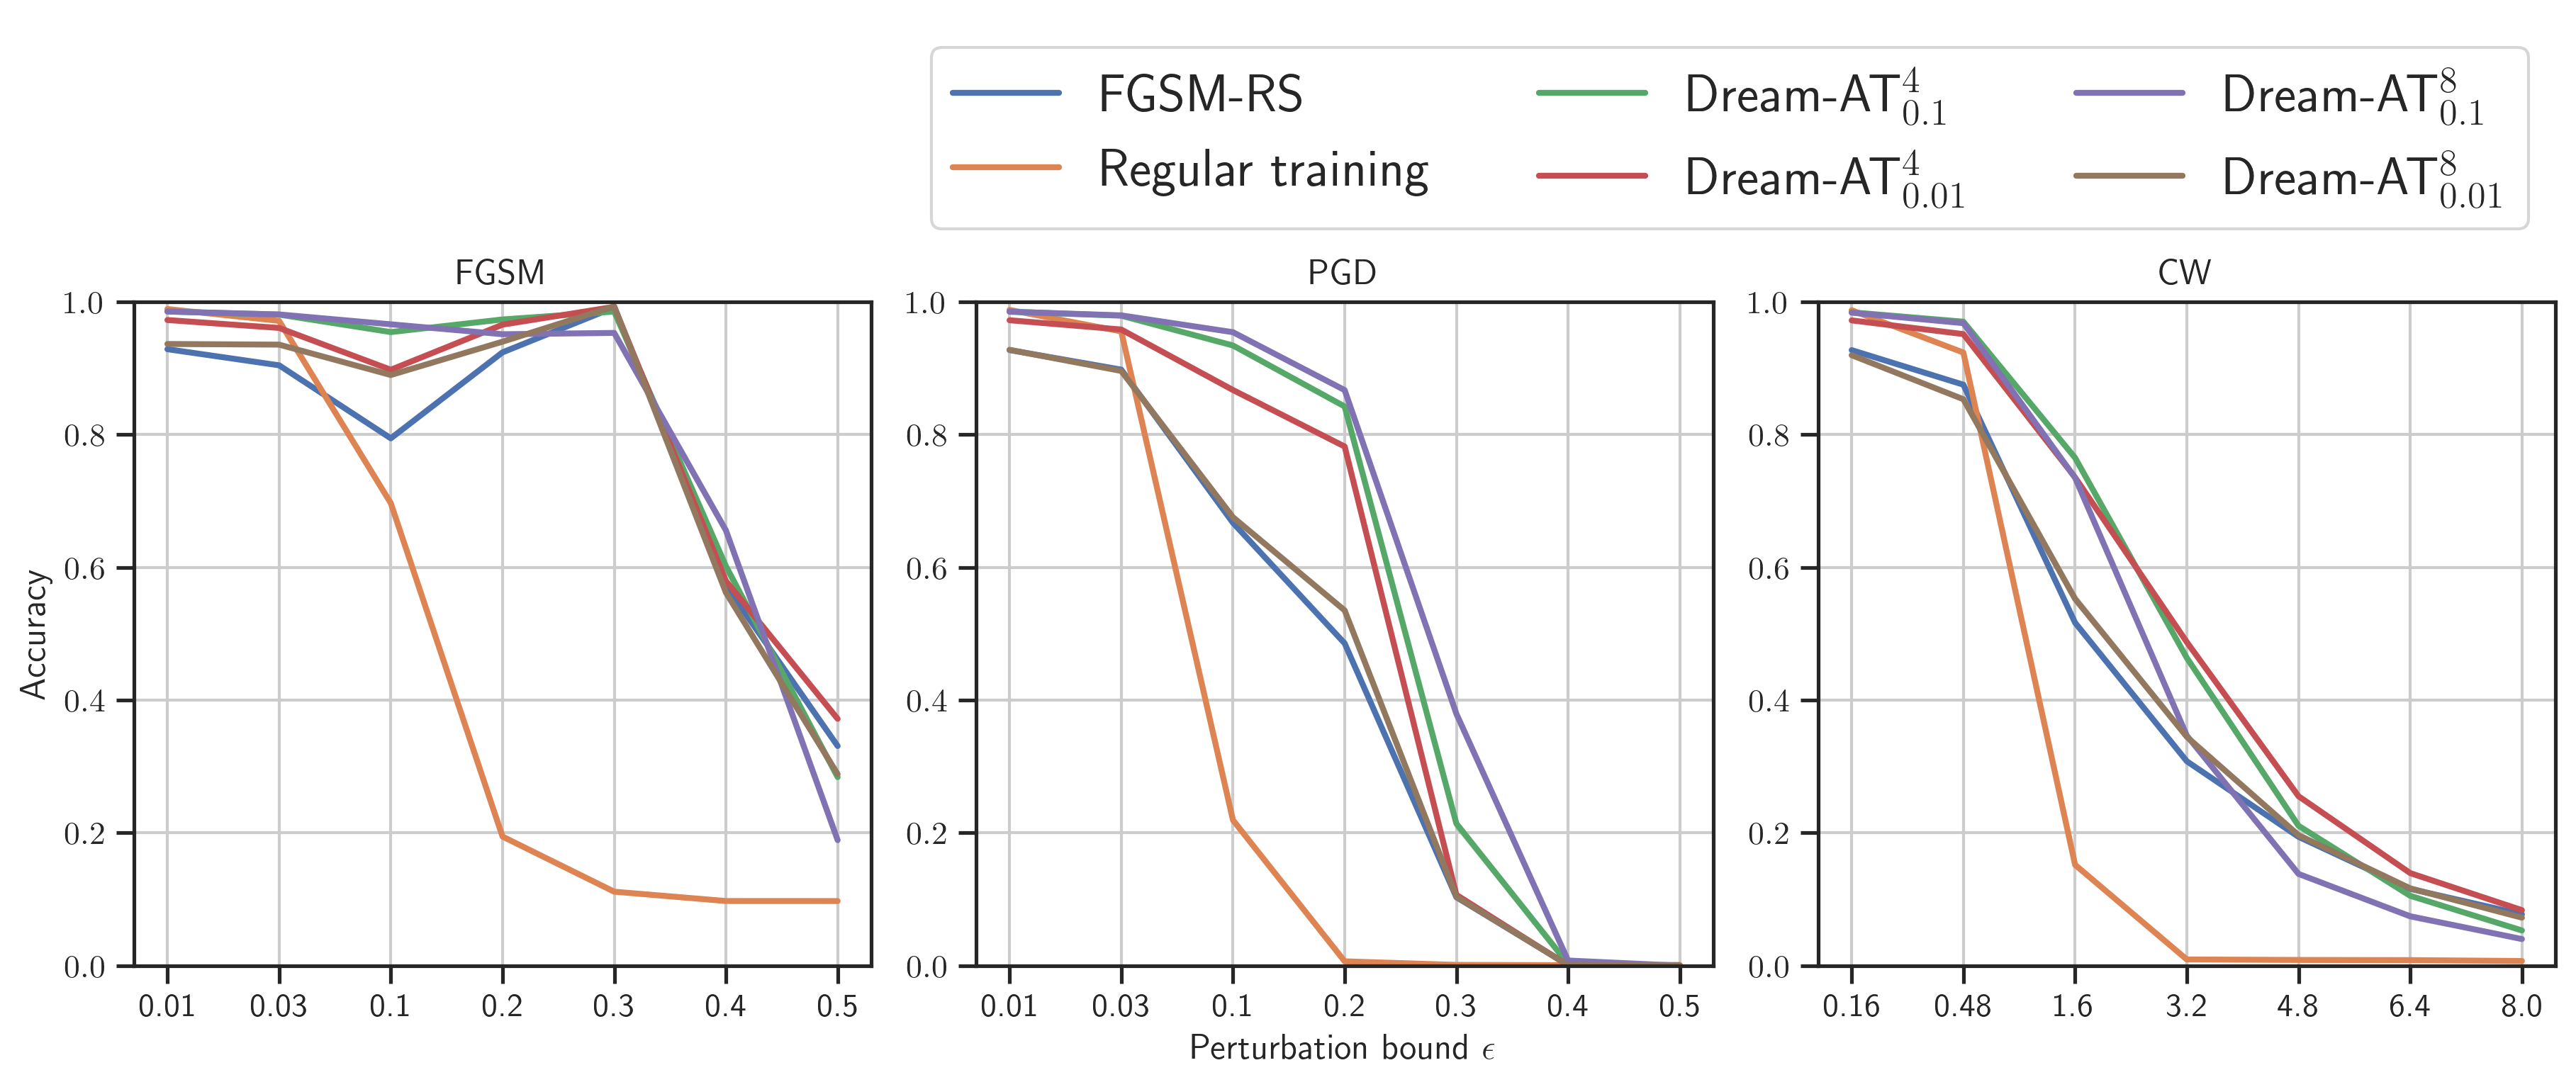

In [882]:
# Other legend style at top


# For attack plots
num_rows, num_cols = 2, 3

# fig_size = [16,15]


fig_size = [12,5]


#  Specify start row and col, make sure all figs fit within figure subplots
start_row = 1
start_col = 0
fig_num   = 0

fig = plt.figure(constrained_layout=True, figsize=fig_size)
gs = GridSpec(num_rows, num_cols, figure=fig, height_ratios=[1] + [3] * (num_rows - 1))

ax_legend = fig.add_subplot(gs[0, :])
_ax_legend = topbar_legend(ax_legend, ncol=3, fontsize=18)

for attack_id in ["FGSM", "PGD", "CW"]:
    cur_col_to_plot = ((fig_num + start_col) % num_cols)
    cur_row_to_plot =start_row + (fig_num // num_cols)


    subplot_axs = fig.add_subplot(gs[cur_row_to_plot, cur_col_to_plot])

    subplot_axs.set_ylim(bottom=0, top=1)
    subplot_axs.grid(visible=True)

    axs, _ = createPlot(attack_id, df=df,
        axs=subplot_axs,
        markers=["o"]*6,
        linewidth=2,
        # dashes = {mid: (2, 1) for mid in df.identifier.unique().tolist()},
        # dashes = model_dashes_dict,
        dashes = None,
        )
    if cur_col_to_plot == 0:
        axs.set_ylabel('Accuracy')
    else:
        axs.set_ylabel('')

    if cur_col_to_plot == 1:
        axs.set_xlabel("Perturbation bound $\epsilon$")
    else:
        axs.set_xlabel('')

    
    fig_num += 1

if save_figures:
    plt.savefig(f'plot_imgs/test/{data_arch}_{attack_trained}_valresults.pdf')
plt.plot()

In [883]:
# Plots single attack graph
def plot_attack_id(attack_id, df, show_grid, **plargs):
    fig, axs = plt.subplots(ncols=1, nrows=1, figsize=[9,5])



    df_attack = df.loc[(df['attack_id'] == attack_id)].drop(columns=["attack_id"]).transpose().copy()
    df_attack.columns = df_attack.iloc[-1]
    df_attack = df_attack.reindex(sorted(df_attack.columns), axis=1)

    if show_grid:
        sns.set(style="ticks")
        axs.grid(visible=True)

    sns.lineplot(data=df_attack[:-1], 
    ax=axs, 
    legend=True, 
    markers=["o"]*6,
    **plargs)

    axs.set(title=name_transform_dict[attack_id])

    # create_legend(axs[1])

    return fig

In [884]:

# att_id= list(attack_eps_dict.keys())[5]
# , dashes=dashes_dict
# single_plot = plot_attack_id(att_id, df, show_grid=True, linewidth=3)
# plt.plot()

In [885]:
if not only_val_plot:
    # logits_df:pd.DataFrame = pd.read_pickle('exp_res/logits_df_10k.pkl')
    logits_df:pd.DataFrame = pd.read_pickle('32it_lr1e-2.pkl')
    logits_df["logit_value"] = logits_df["logit_value"].astype(float)



In [886]:
if not only_val_plot:
    grouped_df:pd.DataFrame = logits_df.groupby(["img_label", "logit_id", "value_type"])

    total_imgs = 0
    for _class_lbl_idx, _class_lbl in enumerate(class_label_list):
        _class_count = grouped_df.get_group((_class_lbl_idx, "cats", "normal"))["img_index"].nunique()
        print(f"img of class {_class_lbl}: {_class_count}")
        total_imgs += _class_count
    # test_df.get_group((1, "cat"))

    print(f"Total num of images: {total_imgs}")

In [887]:
if not only_val_plot:
    sns.boxplot(data=grouped_df.get_group((0, class_label_list[0], "diff")), x="logit_id", y="logit_value")

    test_df = logits_df.groupby(["img_label", "value_type"])


    _fig, _ax = plt.subplots(1, 1, figsize=[15, 10])

    sns.violinplot(data=test_df.get_group((0, "diff")), x="logit_id", y="logit_value", ax=_ax, dodge=False, width=1.2)
    _ax.grid(True)


In [888]:
import warnings

# catplot data to supplied axes

def create_catplot(axs:plt.Axes, data:pd.Series, plot_type:str = "violinplot", keep_axlabels:bool = True, **kwargs):
    axs.grid(True)
    if "boxplot" in plot_type:
        plot_f = sns.boxplot
    elif "violinplot" in plot_type:
        plot_f = sns.violinplot
    else:
        warnings.warn("plot_type not recognised, violinplot used as fallback", UserWarning)
        plot_f = sns.violinplot

    # (data=data, kind=plot_type, ax=axs)
    plot_f(ax=axs, data=data, **kwargs)
    
    if not keep_axlabels:
        axs.set(xlabel = None, ylabel=None)
    else:
        axs.set(xlabel = None)


In [889]:
def create_catplot_of_class(class_idx:int, logit_type:str = "diff", plot_type:str = "violinplot", **kwargs):
    _rows, _cols = 2, 5
    _fig, _axes = plt.subplots(_rows, _cols, figsize=[15, 10], sharey=True)

    _to_plot_num = 0

    for i in range(10):
        _cur_col =(_to_plot_num % _cols)
        _cur_row =(_to_plot_num // _cols)
        _ax_to_plot = _axes[_cur_row][_cur_col]

        keep_axes = _cur_col == 0

        plot_data = grouped_df.get_group((class_idx, class_label_list[i], logit_type))

        create_catplot(data = plot_data, axs =_ax_to_plot, plot_type = plot_type, keep_axlabels = keep_axes, x="logit_id", y="logit_value", **kwargs)
        _to_plot_num += 1

    return _fig, _axes


In [890]:

# create_catplot_of_class(class_idx = 0, logit_type="diff", plot_type="boxplot")

In [891]:
if not only_val_plot:
    # Plots the logit diffs for each class:
    for i in range(10):
        _fig, _axs = create_catplot_of_class(i, logit_type="diff", plot_type="violinplot")
        _fig.suptitle(f"Output logit differences for dreams of the {class_label_list[i]} class", fontsize=20)
        plt.savefig(fname=f"plot_imgs/logits_violinplot_{class_label_list[i]}", bbox_inches="tight")


In [892]:

# ax_boxplot1:plt.Axes = sns.boxplot(data=boxplot_df, x="logit_id", y="logit_value",  notch=True)
# ax_boxplot1:plt.Axes = sns.boxplot(data=boxplot_df, x="logit_id", y="logit_value")


# df_to_boxplot = df_to_boxplot.drop(columns=["label"])